In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

#### Load the data

In [3]:
data = pd.read_csv('cruise_ship_info.csv')

In [4]:
data.head()

Ship_name Cruise_line  Age  Tonnage  passengers  length  cabins  \
0      Journey     Azamara    6   30.277        6.94    5.94    3.55   
1        Quest     Azamara    6   30.277        6.94    5.94    3.55   
2  Celebration    Carnival   26   47.262       14.86    7.22    7.43   
3     Conquest    Carnival   11  110.000       29.74    9.53   14.88   
4      Destiny    Carnival   17  101.353       26.42    8.92   13.21   

   passenger_density   crew  
0              42.64   3.55  
1              42.64   3.55  
2              31.80   6.70  
3              36.99  19.10  
4              38.36  10.00

#### Some EDA

In [5]:
data.describe()

Age     Tonnage  passengers      length      cabins  \
count  158.000000  158.000000  158.000000  158.000000  158.000000   
mean    15.689873   71.284671   18.457405    8.130633    8.830000   
std      7.615691   37.229540    9.677095    1.793474    4.471417   
min      4.000000    2.329000    0.660000    2.790000    0.330000   
25%     10.000000   46.013000   12.535000    7.100000    6.132500   
50%     14.000000   71.899000   19.500000    8.555000    9.570000   
75%     20.000000   90.772500   24.845000    9.510000   10.885000   
max     48.000000  220.000000   54.000000   11.820000   27.000000   

       passenger_density        crew  
count         158.000000  158.000000  
mean           39.900949    7.794177  
std             8.639217    3.503487  
min            17.700000    0.590000  
25%            34.570000    5.480000  
50%            39.085000    8.150000  
75%            44.185000    9.990000  
max            71.430000   21.000000

158 datapoints is not a whole lot of data. Some features might have to be scrapped to prevent overfitting

In [6]:
# check for nulls
data.isnull().sum().sum()

0

In [7]:
# view categorical and continous variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
Ship_name            158 non-null object
Cruise_line          158 non-null object
Age                  158 non-null int64
Tonnage              158 non-null float64
passengers           158 non-null float64
length               158 non-null float64
cabins               158 non-null float64
passenger_density    158 non-null float64
crew                 158 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


##### Determine whether 'Cruise_line' is a useful feature 

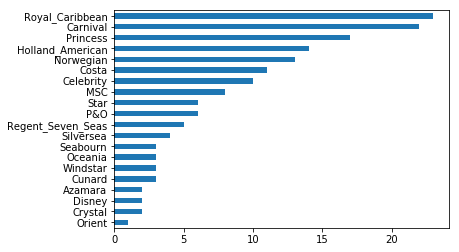

In [8]:
data['Cruise_line'].value_counts().sort_values().plot(kind = 'barh')

Yikes! The data is highly imbalanced across the cruise line category. 
<br> Probably something to consider.

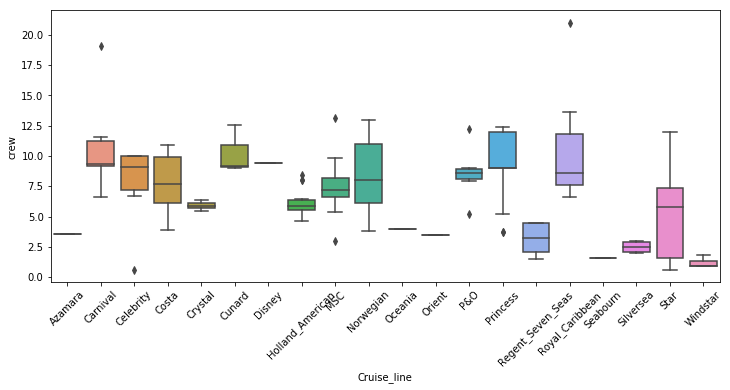

In [9]:
plt.figure(figsize=(12,5))
ax = sns.boxplot(x="Cruise_line", y="crew", data=data)
locs = plt.xticks(rotation=45)

Okay. The distributions across the cruise lines are different.
<br>Most likely a useful feature!

#### Determine if continuous features are good predictors

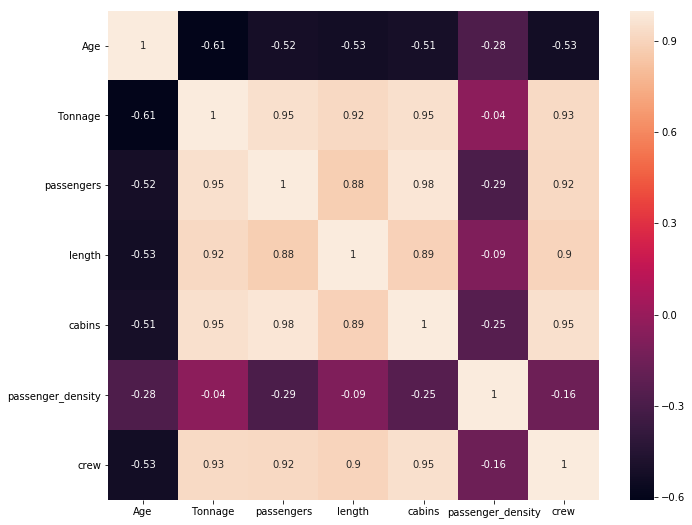

In [10]:
# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(11,9))

correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

plt.show()

Seems Age and Passenger_density are not useful due to low correlation with crew size.
<br> Also we have alot of highly correlated independent features.

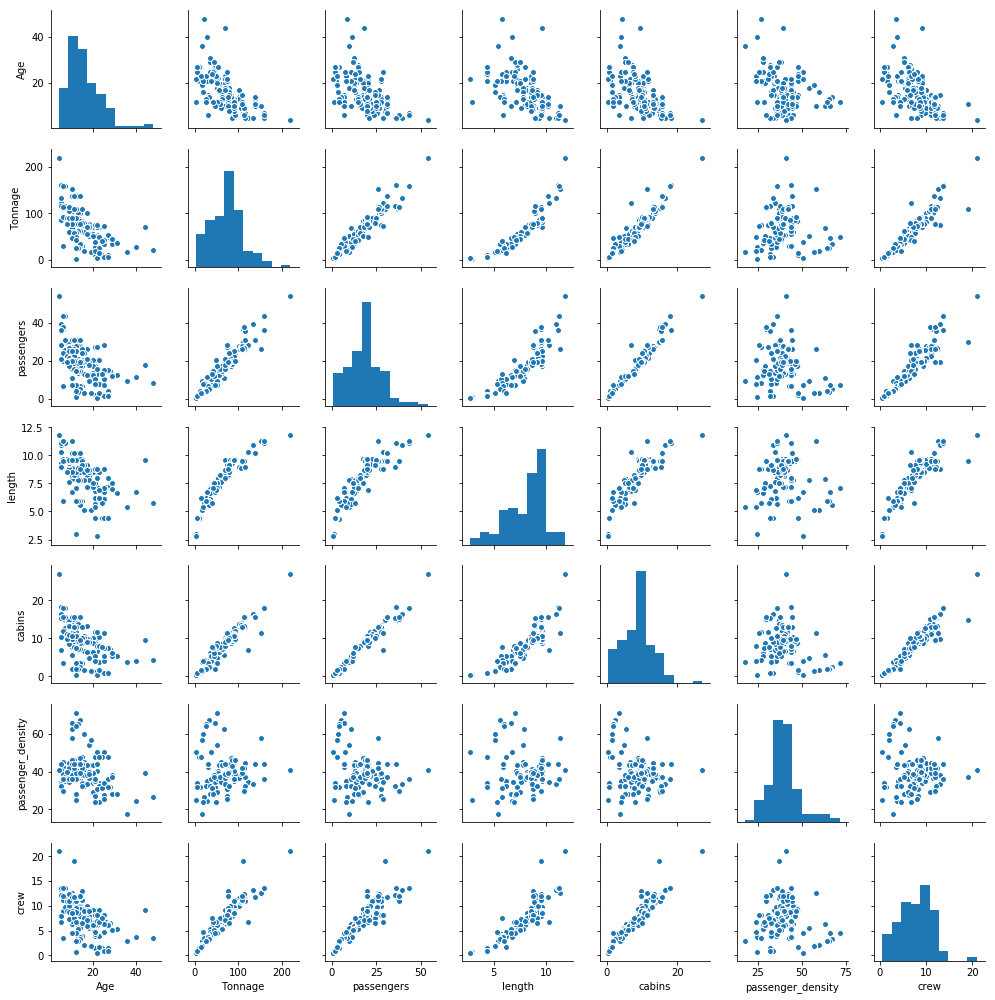

In [11]:
sns.pairplot(data, size=2)

The trend seems to fit a linear pattern and so we will most likely fit a LinearRegressor as a baseline.

In [12]:
data.shape

(158, 9)

In [14]:
X = data[['Tonnage','Cruise_line']]
Y = data['crew']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=22)#, stratify=data['Cruise_line'])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

((126, 2), (32, 2), (126,), (32,))


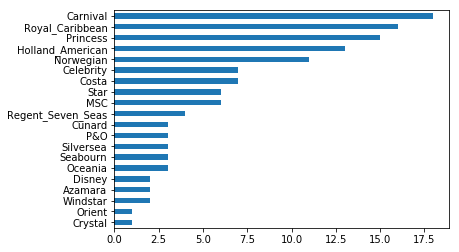

In [16]:
X_train['Cruise_line'].value_counts().sort_values().plot(kind = 'barh')

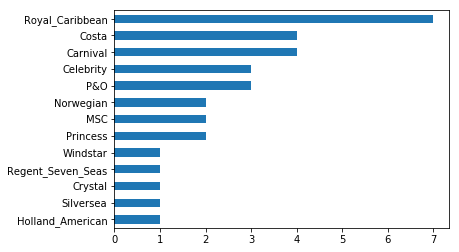

In [17]:
X_test['Cruise_line'].value_counts().sort_values().plot(kind = 'barh')

In [18]:
# scikit-learn modules
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, f1_score

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
cat_features = X_train.dtypes == object
cat_features

Tonnage        False
Cruise_line     True
dtype: bool

In [20]:
# create a method to run the cross validation of the model
def run_cross_validation(model, train_x, train_y, cv=10):
    scores = cross_val_score(model, train_x, train_y, cv=cv)

    print('List of fold scores is: {} '.format(scores))
    print('\n')
    print('The mean score is {}'.format(np.mean(scores)))

In [21]:
transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
                               ('scaler', StandardScaler(), ~cat_features)])

In [22]:
lr = LinearRegression()

lr_pipe = Pipeline([('col_transformer', transformer), ('linear_reg', lr)])

run_cross_validation(lr_pipe, X_train, Y_train)

List of fold scores is: [0.81879715 0.92240311 0.9151745  0.97137649 0.93140904 0.5998102
 0.77893057 0.9328013  0.68938247 0.93299605] 


The mean score is 0.849308086275


In [23]:
ridge_pipe = Pipeline([('col_transformer', transformer), ('ridge', Ridge())])

run_cross_validation(ridge_pipe, X_train, Y_train)

List of fold scores is: [0.85661293 0.92210304 0.92060695 0.96671281 0.94010072 0.5894397
 0.78225722 0.94668934 0.66717811 0.93905226] 


The mean score is 0.853075308274


<b>Ridge regressor seems to have a better cross validation score so let's stick with it.</b>

In [24]:
ridge_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('col_transformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<type 'numpy.float64'>, handle_unknown='ignore',
       n_values=...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [25]:
# model evaluation for training set
y_train_predict = ridge_pipe.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = ridge_pipe.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 1.02199694349
R2 score is 0.909569694734


The model performance for testing set
--------------------------------------
RMSE is 1.22856459112
R2 score is 0.886260420059


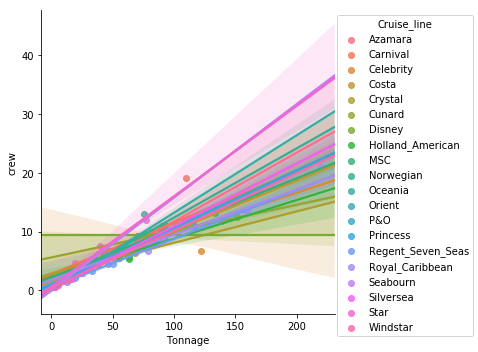

In [26]:
sns.lmplot(x="Tonnage", y="crew", hue="Cruise_line", data=data);

<b>Overall not bad!</b>